# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [3]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [4]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [5]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [6]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [7]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [8]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [9]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [11]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [12]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]])

In [13]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [14]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [15]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [16]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [17]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

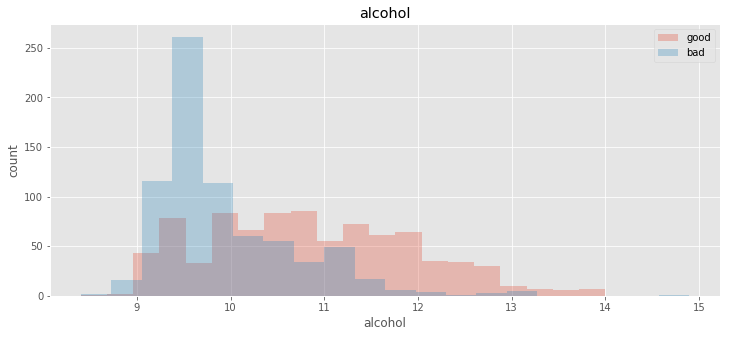

In [18]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [19]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [21]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [22]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [23]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [24]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [25]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [26]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [27]:
from sklearn.metrics.pairwise import euclidean_distances
import random
import pandas as pd

In [169]:
matr = np.arange(10).reshape(5, 2)
matr = np.column_stack((matr, [1,2,3,4,5]))

In [159]:
l = np.array([1,2,3,4,5])
l

array([1, 2, 3, 4, 5])

In [217]:
from sklearn.base import ClusterMixin

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=3, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init_method = init
            
    
    def init_centers(self):
        self.centroids = random.sample(self.X, 1)
        while len(self.centroids) < self.k:
            self.dists = np.array([min([np.linalg.norm(x-c)**2 for c in self.centroids]) for x in self.X])
            self.centroids.append(self._choose_next_center())
            
    def _choose_next_center(self):
        self.probs = self.dists / self.dists.sum()
        self.cumprobs = self.probs.cumsum()
        r = random.random()
        ind = np.where(self.cumprobs >= r)[0][0]
        return(self.X[ind])       
            
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        ## Your Code Here
        self.X = X
        self.y = y
        
        if self.init_method == 'k-means':
            self.init_centers()
        else:
            # Случайным образом выбираем K центроидов из всей выборки (метод 1)
            self.centroids = random.sample(X, self.k)
            df = pd.DataFrame(X, index=None)
            # Случайным образом выбираем K центроидов из всей выборки (метод 2)
            #self.centroids = [map(lambda x: random.uniform(x[0], x[1]), zip(df.min().tolist(), df.max().tolist())) 
            #                 for i in range(self.k)]

        self.init_old = np.array(self.centroids)
        iter_n = 0
        while iter_n < self.max_iter:
            iter_n += 1
            # Считаем расстояние от каждой точки до каждого кластера
            dists = euclidean_distances(X, self.centroids)

            # Для каждой точки из датасета присваиваем кластер, соответствующий ближайшему центроиду
            new_labels = list(map(lambda x: np.argmin(x), dists))
            
            # Если не произошло изменений то завершаем обучение
            if sum([1 for new, old in zip(new_labels, self.labels) if new != old]) == 0: break
            
            self.labels = new_labels
            #print(self.labels)

            df = pd.DataFrame(X, index=None)
            df[df.shape[1]] = self.labels
            
            
            for i in range(self.k):
                df_i = df.loc[df[df.shape[1]-1] == i]
                count = df_i.shape[0]
                if count > 0: self.centroids[i] = [item / count for item in df_i.sum().tolist()[:-1]]
                    
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        return np.column_stack((X, self.labels))
        

class MiniBatchKMeans(Kmeans):
    def __init__(self, batch_size = 100, k=3, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        super(MiniBatchKMeans, self).__init__(k, metric, max_iter, random_state, init)
        self.batch_size = batch_size
        
    def fit(self, X, y=None):
        if X.shape[0] < self.batch_size:
            self.batch_size = X.shape[0]
        
        # Initialize each c ∈ C with an x picked randomly from X
        self.centroids = random.sample(X, self.k)
        self.init_old = np.array(self.centroids)
        v = np.zeros(len(self.centroids))
        for i in range(self.max_iter):
            M = random.sample(X, self.batch_size) # b examples picked randomly from X
            
            # For each x in M cache the center nearest to x in d
            dists = euclidean_distances(M, self.centroids)
            cluster_numbers = list(map(lambda x: np.argmin(x), dists))
            #d = [self.centroids[j] for j in cluster_numbers]
            
            for j, x in enumerate(M):
                index = cluster_numbers[j]
                c = self.centroids[index]               # Get cached center for this x from d
                v[index] += 1                           # Update per-center counts
                rate = float(1) / v[index]              # Get per-center learning rate
                self.centroids[index] = (1 - rate) * c + rate * x # Take gradient step
                
        dists = euclidean_distances(X, self.centroids)
        self.labels = list(map(lambda x: np.argmin(x), dists))
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [218]:
from sklearn.datasets import make_blobs, make_biclusters

In [221]:
X, y = make_blobs(n_samples=3000, n_features=2, centers=5, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

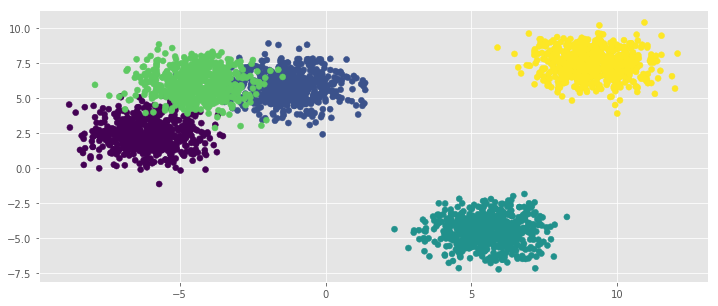

In [222]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

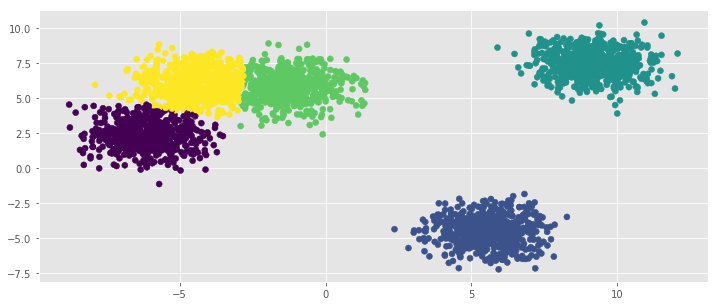

In [223]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
k_means = KMeans(n_clusters=5)
k_means.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=k_means.labels_)

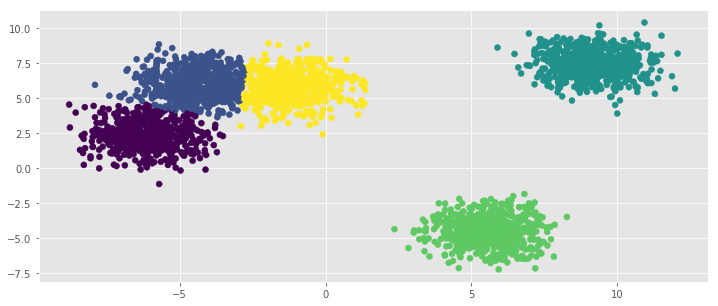

In [224]:
## Работоспособность KMeans
kmeans = Kmeans(k=5)
kmeans.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=kmeans.labels)

In [225]:
adjusted_rand_score(k_means.labels_, kmeans.labels)

0.99831737561832612

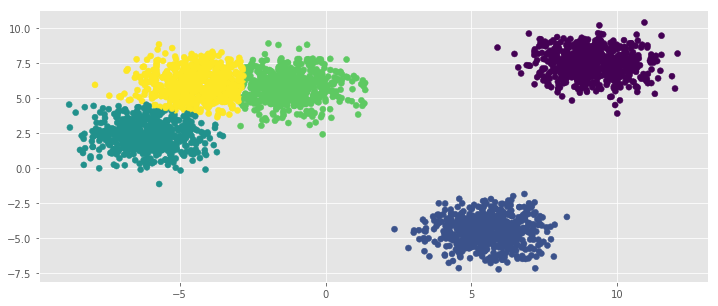

In [226]:
## Работоспособность KMeans++
kmeans_pp = Kmeans(k=5, init='k-means')
kmeans_pp.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=kmeans_pp.labels)

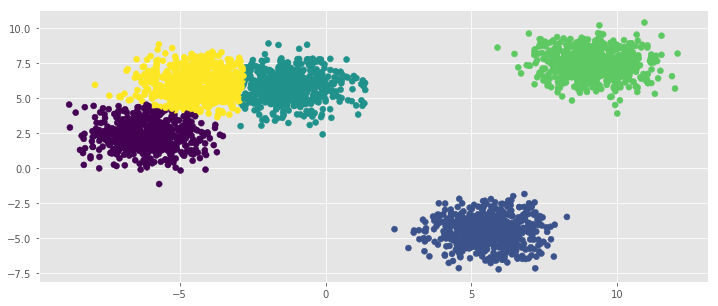

In [229]:
## Работоспособность KMeans с MiniBatchKMeans
mb_kmeans = MiniBatchKMeans(k=5)
mb_kmeans.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=mb_kmeans.labels)

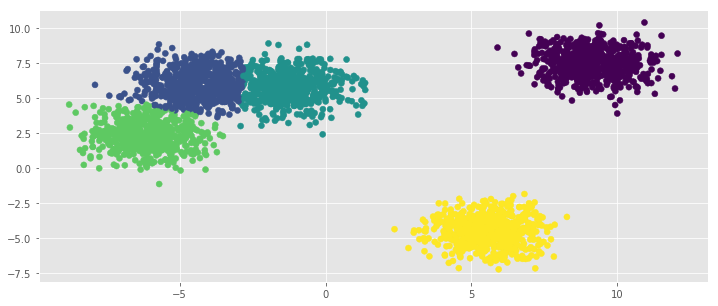

In [231]:
## Работоспособность KMeans++ с MiniBatchKMeans
mb_kmeans_pp = MiniBatchKMeans(k=5, init='k-means')
mb_kmeans_pp.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=mb_kmeans_pp.labels)

In [232]:
import time

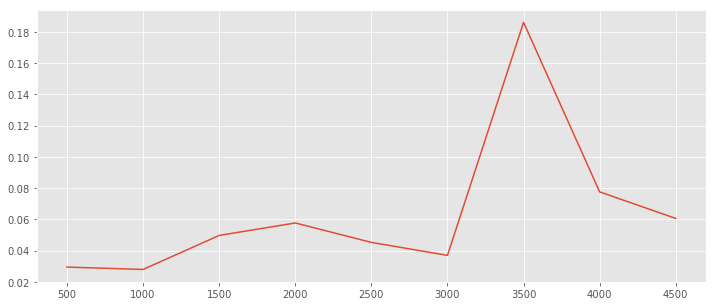

In [233]:
## Время выполнения алгоритма KMeans
num_samples = range(500, 5000, 500)
k = 3
times = []
for n in num_samples:
    start = time.time()
    X, y = make_blobs(n_samples=n, n_features=2, centers=k, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    kmeans = Kmeans(k=k)
    kmeans.fit(X, y)
    times.append(time.time()-start)
plt.figure()
plt.plot(num_samples, times)

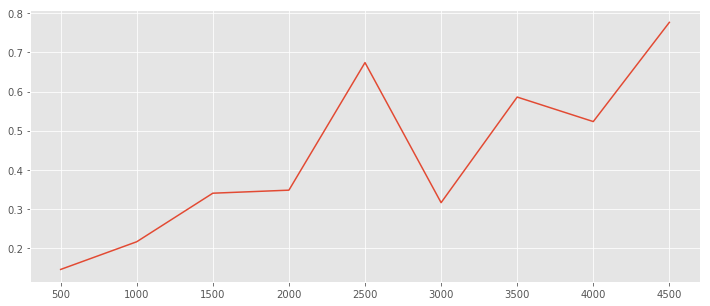

In [234]:
## Время выполнения алгоритма KMeans++
num_samples = range(500, 5000, 500)
k = 3
times = []
for n in num_samples:
    start = time.time()
    X, y = make_blobs(n_samples=n, n_features=2, centers=k, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    mb_kmeans_pp = MiniBatchKMeans(k=k)
    kmeans_pp.fit(X, y)
    times.append(time.time()-start)
plt.figure()
plt.plot(num_samples, times)

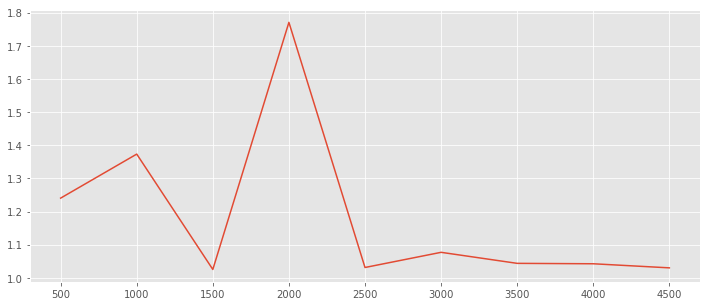

In [237]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
num_samples = range(500, 5000, 500)
k = 3
times = []
for n in num_samples:
    start = time.time()
    X, y = make_blobs(n_samples=n, n_features=2, centers=k, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    mb_kmeans = MiniBatchKMeans(k=k)
    mb_kmeans.fit(X, y)
    times.append(time.time()-start)
plt.figure()
plt.plot(num_samples, times)

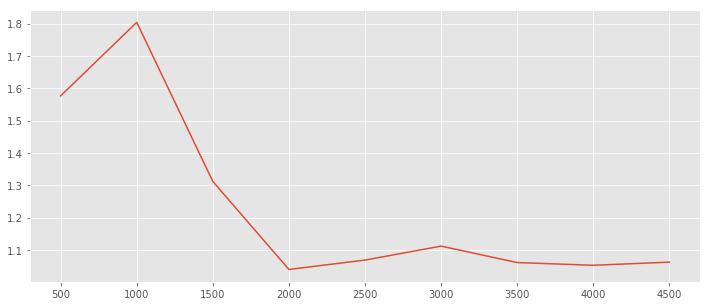

In [238]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans
num_samples = range(500, 5000, 500)
k = 3
times = []
for n in num_samples:
    start = time.time()
    X, y = make_blobs(n_samples=n, n_features=2, centers=k, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    mb_kmeans_pp = MiniBatchKMeans(k=k, init='k-means')
    mb_kmeans_pp.fit(X, y)
    times.append(time.time()-start)
plt.figure()
plt.plot(num_samples, times)

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [239]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [240]:
df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis=1, inplace=True)
df_sns.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [241]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_st = scaler.fit_transform(df_sns.values)

In [247]:
## KMeans
kmeans = Kmeans(k=9)
kmeans.fit(X_st)

Kmeans(init=None, k=9, max_iter=1000, metric='euclidean', random_state=None)

In [250]:
orig_kmeans = KMeans(n_clusters=9, init=kmeans.init_old)
orig_kmeans.fit(X_st)

KMeans(algorithm='auto', copy_x=True,
    init=array([[-0.33222, -0.3577 , ..., -0.2204 , -0.17491],
       [-0.33222, -0.3577 , ..., -0.2204 , -0.17491],
       ...,
       [-0.33222, -0.3577 , ..., -0.2204 , -0.17491],
       [-0.33222,  1.06005, ..., -0.2204 , -0.17491]]),
    max_iter=300, n_clusters=9, n_init=10, n_jobs=1,
    precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

In [251]:
adjusted_rand_score(kmeans.labels, orig_kmeans.labels_)

0.99934139554202983

In [253]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#from sklearn.datasets import load_iris
#iris = load_iris()

#X_tsne = TSNE(learning_rate=100).fit_transform(iris.data)

In [254]:
## KMeans++
kmeans_pp = Kmeans(k=9, init='k-means')
kmeans_pp.fit(X_st)

Kmeans(init=None, k=9, max_iter=1000, metric='euclidean', random_state=None)

In [255]:
orig_kmeans_pp = KMeans(n_clusters=9, init=kmeans_pp.init_old)
orig_kmeans_pp.fit(X_st)

KMeans(algorithm='auto', copy_x=True,
    init=array([[-0.33222, -0.3577 , ..., -0.2204 , -0.17491],
       [-0.33222, -0.3577 , ...,  7.29617, -0.17491],
       ...,
       [-0.33222, -0.3577 , ..., -0.2204 , -0.17491],
       [-0.33222, -0.3577 , ..., -0.2204 , -0.17491]]),
    max_iter=300, n_clusters=9, n_init=10, n_jobs=1,
    precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

In [256]:
adjusted_rand_score(orig_kmeans_pp.labels_, kmeans_pp.labels)

0.99849087669122483

In [257]:
## KMeans с MiniBatchKMeans
mb_kmeans = MiniBatchKMeans(k=9)
mb_kmeans.fit(X_st)

MiniBatchKMeans(batch_size=100, init=None, k=9, max_iter=1000,
        metric='euclidean', random_state=None)

In [258]:
orig_mb_kmeans = MiniBatchKMeans(k=9, init=mb_kmeans.init_old)
orig_mb_kmeans.fit(X_st)

MiniBatchKMeans(batch_size=100, init=None, k=9, max_iter=1000,
        metric='euclidean', random_state=None)

In [259]:
adjusted_rand_score(orig_mb_kmeans.labels, mb_kmeans.labels)

0.6677218118059024

In [285]:
## KMeans++ с MiniBatchKMeans
mb_kmeans_pp = MiniBatchKMeans(k=9, init='k-means')
mb_kmeans_pp.fit(X_st)

MiniBatchKMeans(batch_size=100, init=None, k=9, max_iter=1000,
        metric='euclidean', random_state=None)

In [286]:
orig_mb_kmeans_pp = MiniBatchKMeans(k=9, init=mb_kmeans_pp.init_old)
orig_mb_kmeans_pp.fit(X_st)

MiniBatchKMeans(batch_size=100, init=None, k=9, max_iter=1000,
        metric='euclidean', random_state=None)

In [287]:
adjusted_rand_score(orig_mb_kmeans_pp.labels, mp_kmeans_pp.labels)

0.70124008364506341

#### Визуализация

In [136]:
X_tsne = TSNE(learning_rate=200).fit_transform(X_st)

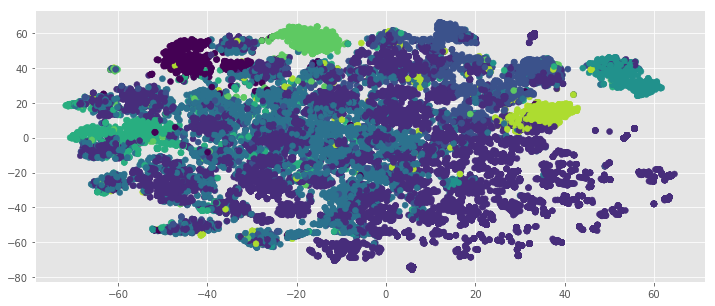

In [150]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=orig_kmeans.labels_)

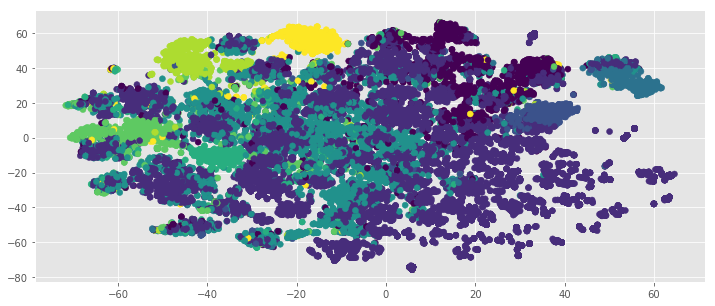

In [151]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels)

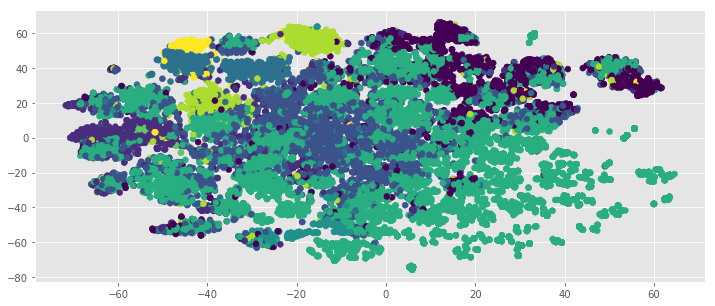

In [269]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_pp.labels)

In [284]:
len(set(mb_kmeans_pp.labels))

3

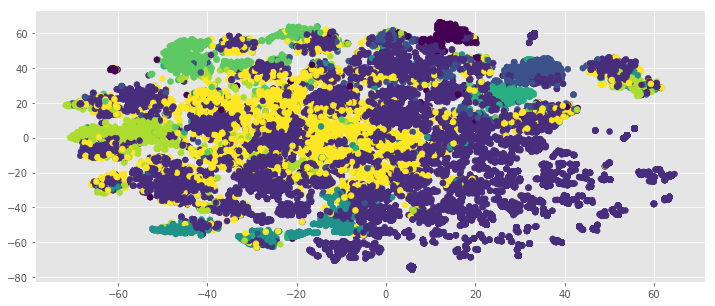

In [272]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=mb_kmeans.labels)

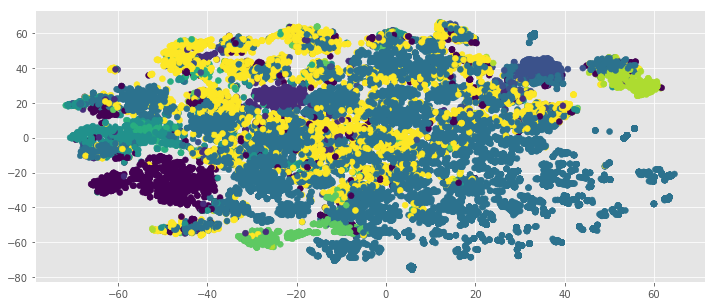

In [288]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=mb_kmeans_pp.labels)

In [191]:
df_clustered = pd.concat([pd.read_csv('snsdata.csv', sep=','), pd.DataFrame(kmeans_pp.labels, columns=['flag'])], axis=1)
df_clustered.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs,flag
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,2006,F,18.801,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,7
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,2,0,0,0,0,0,1,1,1


In [290]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

height has been deprecated.



In [306]:
[df_clustered[df_clustered.flag == i].shape[0] for i in list(set(df_clustered.flag))]

[3114, 963, 125, 574, 2700, 886, 499, 20642, 497]

In [292]:
df_clustered.drop(['gradyear', 'gender'], axis=1).groupby('flag').mean()

,age,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching,music,rock,god,church,jesus,bible,hair,dress,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
flag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,17.567668,38.896596,0.281952,0.314708,0.219653,0.116891,0.184008,0.171805,0.443481,0.083494,0.115928,0.122030,1.039820,0.216442,0.327874,0.491972,0.096981,1.274566,0.195568,0.002890,1.011240,0.316635,0.524406,0.430315,0.109827,0.004817,0.874759,0.405267,0.168593,0.908157,1.182723,0.458574,0.475915,0.359345,0.201670,0.152537,0.099550,0.043995
1,17.600538,30.709242,0.562825,0.510903,0.342679,0.199377,0.200415,0.219107,0.202492,0.228453,0.151610,0.495327,0.706127,2.598131,0.425753,0.262721,1.705088,0.966771,0.731049,0.036345,2.266874,1.138110,0.970924,0.365524,0.146417,0.028037,3.310488,0.352025,0.825545,0.687435,0.552440,0.735202,0.172378,0.166147,1.284528,0.539979,0.816199,1.037383
2,18.048886,32.872000,0.208000,0.464000,0.104000,0.160000,0.112000,0.168000,0.064000,0.032000,0.168000,0.096000,0.328000,0.232000,0.176000,0.112000,0.200000,0.600000,8.424000,2.984000,1.760000,0.528000,0.504000,0.224000,0.064000,0.016000,0.512000,0.120000,0.072000,0.256000,0.416000,0.192000,0.008000,0.024000,0.296000,0.128000,0.064000,0.064000
3,18.874348,35.080139,0.313589,0.273519,0.212544,0.118467,0.149826,0.134146,0.108014,0.088850,0.128920,0.134146,0.311847,0.179443,0.083624,0.127178,0.076655,0.428571,0.378049,0.026132,1.034843,0.315331,4.191638,2.158537,1.803136,0.878049,0.487805,0.127178,0.104530,0.203833,0.386760,0.168990,0.038328,0.024390,0.324042,0.245645,0.118467,0.074913
4,17.656589,33.107407,1.261852,1.247407,1.076667,0.182222,0.602222,0.115185,0.118519,0.672222,0.242593,0.611481,0.315185,0.169630,0.135926,0.118148,0.054444,0.430000,0.190741,0.003704,0.805185,0.367778,0.465185,0.319630,0.095185,0.005926,0.408889,0.072963,0.164815,0.237037,0.335185,0.130370,0.026667,0.012963,0.150370,0.094444,0.063333,0.031111
5,17.801058,32.058691,0.173815,0.222348,0.163657,0.085779,0.069977,0.117381,0.054176,0.059819,0.097065,0.076749,0.291196,0.144470,0.119639,0.088036,0.055305,0.436795,3.310384,0.854402,1.189616,0.323928,0.459368,0.256208,0.117381,0.013544,0.369074,0.125282,0.072235,0.193002,0.266366,0.139955,0.016930,0.011287,0.176072,0.141084,0.065463,0.023702
6,17.698012,32.805611,0.256513,0.298597,0.280561,0.118236,0.202405,2.827655,0.086172,0.122244,0.110220,0.128257,0.414830,0.154309,0.134269,0.168337,0.110220,0.414830,0.256513,0.016032,0.913828,0.268537,0.494990,0.254509,0.100200,0.020040,0.476954,0.108216,0.116232,0.314629,0.641283,0.236473,0.072144,0.048096,0.170341,0.132265,0.116232,0.034068
7,18.130255,27.902238,0.111811,0.095679,0.108614,0.059200,0.066466,0.062203,0.052660,0.028679,0.057649,0.061816,0.196153,0.106869,0.102897,0.066466,0.037884,0.269305,0.129881,0.000000,0.575816,0.165682,0.326955,0.149501,0.066370,0.002277,0.217954,0.057746,0.045732,0.142380,0.212237,0.072183,0.012741,0.006734,0.130753,0.084972,0.055518,0.023011
8,17.505021,40.885312,0.798793,0.388330,0.201207,4.714286,0.537223,0.156942,0.110664,0.185111,0.064386,0.390342,0.368209,0.211268,0.142857,0.146881,0.100604,0.442656,0.297787,0.022133,0.843058,0.275654,0.529175,0.368209,0.110664,0.014085,0.509054,0.173038,0.136821,0.352113,0.521127,0.229376,0.078471,0.062374,0.179074,0.150905,0.068410,0.058350


## Вывод
Исходя из значений в полученной таблице можно увидеть некоторую интерпретацию кластеров.Например:
###### 1) Кластер 8 - спортивные люди, играющие в софтбол и немного в баскетбол
###### 2) Кластер 6 - люди, занимающиеся плаванием
###### 3) Кластер 4 - футбол, американский футбол и баскетбол и немного волейбол
###### 4) Кластер 1 - пьющие люди и наркоманы, склонные к суициду, слушающие рок
###### 5) Кластер 2 - люди, играющие в музыкальной группе
###### 6) Кластер 3 - религиозные люди, посещающие церковь и читающие библию
###### 7) Кластер 4 - спортсмены, играющие в баскетбол, футбол, бейсбол, волейбол и американский футбол
###### 8) Кластер 5 - люди, которым нравится музыка и которые играют в группах

###### 9) Кластер 7 - собирательный образ выборки, нет конкретно выделенных особенностей, также он самый большой

Из рисунков, построенных в пространстве меньшей размерности, видно, что некоторые кластеры более-менее хорошо выражены, а некоторые размазаны по всему пространству